In [1]:
# === DNA VARIANT CROSS-DISEASE ANALYSIS — SETUP ===
import os, glob, re, sys, math, textwrap
from pathlib import Path, PurePath
import pandas as pd
import matplotlib.pyplot as plt

# Create folders
Path("data_raw").mkdir(exist_ok=True)
Path("data_cleaned").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

def banner(msg):
    line = "━" * len(msg)
    print(f"\n{line}\n{msg}\n{line}")


banner("Ready. uploading four datasets to colab.")



━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Ready. uploading four datasets to colab.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [ ]:
banner("Auto-detecting input files")

def pick(patterns):
    for p in patterns:
        hits = glob.glob(f"data_raw/{p}")
        if hits: return hits[0]
    return None

files_map = {
    "alzheimers": pick(["alz*.*","Alz*.*"]),
    "t2d":        pick(["type2*.*","t2d*.*","Type2*.*","T2D*.*"]),
    "cad":        pick(["cad*.*","CAD*.*"]),
    "ra":         pick(["ra*.*","RA*.*"]),
}
print("Detected:", files_map)

missing = [k for k,v in files_map.items() if not v]
if missing:
    raise FileNotFoundError(f"Missing files for: {missing}. "
                            "Rename the files in data_raw/ so they start with alz, type2/t2d, cad, ra.")
else:
    banner("All 4 inputs detected ")



━━━━━━━━━━━━━━━━━━━━━━━━━━
Auto-detecting input files
━━━━━━━━━━━━━━━━━━━━━━━━━━
Detected: {'alzheimers': 'data_raw/alzheimers_gwas.csv', 't2d': 'data_raw/type2diabetes_gwas.csv', 'cad': 'data_raw/cad_gwas.tsv', 'ra': 'data_raw/ra_gwas.tsv'}

━━━━━━━━━━━━━━━━━━━━━━
All 4 inputs detected 
━━━━━━━━━━━━━━━━━━━━━━


In [ ]:
banner("Loading & cleaning")

def read_any(path):
    """Try TSV then CSV, then auto-detect."""
    try:
        df = pd.read_csv(path, sep="\t", low_memory=False)
        if df.shape[1] > 1: return df
    except Exception: pass
    try:
        df = pd.read_csv(path, sep=",", low_memory=False)
        if df.shape[1] > 1: return df
    except Exception: pass
    return pd.read_csv(path, sep=None, engine="python", low_memory=False)

def coerce_pvalue(x):
    if pd.isna(x): return math.nan
    s = str(x).strip()
    s = (s.replace(",", "")
          .replace("×","x")
          .replace("−","-")
          .replace("–","-")
          .replace(" ", ""))
    # plain float
    try: return float(s)
    except Exception: pass
    # 1x10^-8 style
    m = re.match(r"^([0-9]*\.?[0-9]+)[x\*]10\^(-?\d+)$", s, flags=re.I)
    if m: return float(m.group(1)) * (10 ** int(m.group(2)))
    # scientific e/E
    m2 = re.search(r"([0-9]*\.?[0-9]+)[eE](-?\d+)", s)
    if m2: return float(m2.group(1)) * (10 ** int(m2.group(2)))
    # last resort: first number
    m3 = re.search(r"([0-9]*\.?[0-9]+)", s)
    return float(m3.group(1)) if m3 else math.nan

def load_and_clean(path):
    df = read_any(path)

    # find a p-value column
    pcol = None
    for c in ["P-VALUE","p-value","P_VALUE","p_value","P-VALUE (TEXT)","PVALUE"]:
        if c in df.columns: pcol = c; break
    if pcol is None and "PVALUE_MLOG" in df.columns:
        df["__p"] = 10 ** (-pd.to_numeric(df["PVALUE_MLOG"], errors="coerce")); pcol="__p"
    if pcol is None:
        for c in df.columns:
            if c.strip().lower().startswith("p-value"): pcol = c; break
    if pcol is None:
        raise ValueError(f"No p-value column found in {PurePath(path).name}. First columns: {list(df.columns)[:10]}")

    keep = [c for c in ["SNPS","CHR_ID","CHR_POS","MAPPED_GENE","CONTEXT","RISK ALLELE FREQUENCY", pcol] if c in df.columns]
    df = df[keep].copy()

    df["__pval"] = pd.to_numeric(df[pcol].map(coerce_pvalue), errors="coerce")
    df = df[df["__pval"] < 5e-8].copy()

    colmap = {"SNPS":"rsid","CHR_ID":"chr","CHR_POS":"pos","MAPPED_GENE":"gene",
              "CONTEXT":"context","RISK ALLELE FREQUENCY":"raf", pcol:"pvalue"}
    df = df.rename(columns=colmap)

    if "gene" in df.columns:
        df["gene"] = df["gene"].fillna("").astype(str)
        df["gene"] = df["gene"].str.replace(r"\s*[-;]\s*", ",", regex=True)
        df = df.assign(gene=df["gene"].str.split(",")).explode("gene")
        df["gene"] = df["gene"].str.strip()
        df = df[df["gene"] != ""]
    out = Path("data_cleaned")/f"{PurePath(path).stem}_sig.csv"
    df.drop_duplicates().to_csv(out, index=False)
    return df

clean = {trait: load_and_clean(path) for trait, path in files_map.items()}
for trait, df in clean.items():
    print(f"{trait}: {len(df):,} significant rows")

# summary table
gene_sets = {t: set(df["gene"].dropna().unique()) for t, df in clean.items()}
summary = pd.DataFrame({
    "trait": list(clean.keys()),
    "n_sig_variants": [len(clean[t]) for t in clean],
    "n_unique_genes": [len(gene_sets[t]) for t in gene_sets],
}).sort_values("trait")
summary.to_csv("data_cleaned/summary_counts.csv", index=False)
summary



━━━━━━━━━━━━━━━━━━
Loading & cleaning
━━━━━━━━━━━━━━━━━━
alzheimers: 4,706 significant rows
t2d: 9,305 significant rows
cad: 4,381 significant rows
ra: 6,559 significant rows


,trait,n_sig_variants,n_unique_genes
0,alzheimers,4706,1922
2,cad,4381,1032
3,ra,6559,944
1,t2d,9305,2494


In [ ]:
banner("Computing overlaps & saving shared genes")

all_genes = sorted(set().union(*gene_sets.values()))
shared_ge2 = sorted([g for g in all_genes if sum(g in s for s in gene_sets.values()) >= 2])

pd.Series(sorted(gene_sets["alzheimers"])).to_csv("data_cleaned/alzheimers_genes.csv", index=False)
pd.Series(sorted(gene_sets["t2d"])).to_csv("data_cleaned/t2d_genes.csv", index=False)
pd.Series(sorted(gene_sets["cad"])).to_csv("data_cleaned/cad_genes.csv", index=False)
pd.Series(sorted(gene_sets["ra"])).to_csv("data_cleaned/ra_genes.csv", index=False)
pd.Series(shared_ge2).to_csv("data_cleaned/shared_genes_ge2.txt", index=False, header=False)

print(f"Shared genes (>=2 diseases): {len(shared_ge2)}")
print("Saved to: data_cleaned/shared_genes_ge2.txt  ← upload this to Reactome/DAVID")



━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Computing overlaps & saving shared genes
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Shared genes (>=2 diseases): 891
Saved to: data_cleaned/shared_genes_ge2.txt  ← upload this to Reactome/DAVID


Looking in data_cleaned/ ...
Found files: ['cad_gwas_sig.csv', 'ra_gwas_sig.csv', 'alzheimers_gwas_sig.csv', 'shared_genes_ge2.txt', 'alzheimers_genes.csv', 'type2diabetes_gwas_sig.csv', 't2d_genes.csv', 'summary_counts.csv', 'ra_genes.csv', 'cad_genes.csv']
Traits detected and gene counts:
- cad_gwas: 1032 genes
- ra_gwas: 944 genes
- alzheimers_gwas: 1922 genes
- type2diabetes_gwas: 2494 genes


/usr/local/lib/python3.11/dist-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

<Figure size 640x480 with 0 Axes>

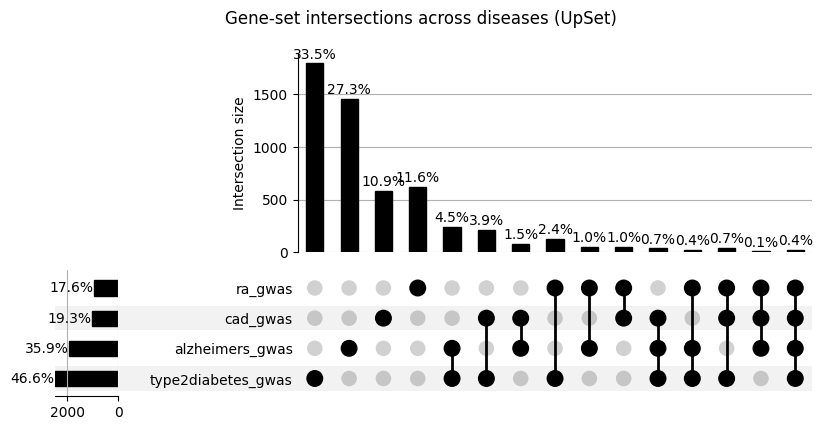

Saved figure: data_cleaned/upset_intersections.png


In [ ]:
# ==== Build gene sets robustly and draw an UpSet plot ====
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships

# 1) Diagnose what's available
print("Looking in data_cleaned/ ...")
print("Found files:", os.listdir("data_cleaned") if os.path.exists("data_cleaned") else "data_cleaned not found")

# 2) Build gene_sets from *_genes.csv if available; otherwise from *_sig.csv
gene_sets = {}

# Try *_genes.csv (preferred)
for f in glob.glob("data_cleaned/*_genes.csv"):
    trait = os.path.basename(f).replace("_genes.csv", "")
    df = pd.read_csv(f)
    if "gene" in df.columns:
        genes = set(df["gene"].dropna().astype(str))
        genes = {g.strip() for g in genes if g.strip()}
        if genes:
            gene_sets[trait] = genes

# Fallback: derive from *_sig.csv if needed
if len(gene_sets) < 4:
    for f in glob.glob("data_cleaned/*_sig.csv"):
        trait = os.path.basename(f).replace("_sig.csv", "")
        if trait in gene_sets:  # already filled from *_genes.csv
            continue
        df = pd.read_csv(f, low_memory=False)
        if "gene" in df.columns:
            genes = set(df["gene"].dropna().astype(str))
            genes = {g.strip() for g in genes if g.strip()}
            if genes:
                gene_sets[trait] = genes

print("Traits detected and gene counts:")
for k,v in gene_sets.items():
    print(f"- {k}: {len(v)} genes")

if len(gene_sets) < 2:
    raise ValueError("Not enough traits with genes. Ensure cleaned files are in data_cleaned/ and contain a 'gene' column.")

# 3) Build memberships for UpSet
all_genes = sorted(set().union(*gene_sets.values()))
memberships = []
for g in all_genes:
    belongs = [trait for trait, s in gene_sets.items() if g in s]
    memberships.append(belongs)

# Guard against empty categories
if not any(memberships) or all(len(m)==0 for m in memberships):
    raise ValueError("Memberships are empty—no overlaps built. Check that gene_sets above are non-empty.")

# 4) Make and save the UpSet plot
from upsetplot import from_memberships
data = from_memberships(memberships)

plt.figure()
UpSet(data, subset_size='count', show_percentages=True).plot()
plt.suptitle("Gene-set intersections across diseases (UpSet)")
plt.savefig("data_cleaned/upset_intersections.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved figure: data_cleaned/upset_intersections.png")


In [ ]:
banner("Load Reactome enrichment results (CSV/XLS) and summarize")

# If you downloaded CSV from Reactome, upload it (Colab):
# from google.colab import files
# up = files.upload()
# # ensure the filename below matches what you uploaded
reactome_path = sorted(glob.glob("shared_genes_ge2.csv") + glob.glob("data_cleaned/shared_genes_ge2.csv") + glob.glob("*.csv"))
if not reactome_path:
    print(" Upload your Reactome enrichment CSV and rerun this cell.")
else:
    reactome_path = reactome_path[0]
    print("Using:", reactome_path)

reactome = pd.read_csv(reactome_path) if reactome_path else pd.DataFrame()

def select_cols(df):
    keep = []
    for c in df.columns:
        cl = c.lower()
        if ("pathway" in cl and "name" in cl) or cl == "pathway name":
            keep.append(c)
        if ("entities" in cl and any(k in cl for k in ["pvalue","fdr","ratio","found","total"])):
            keep.append(c)
        if cl in {"species name","species identifier"}:
            keep.append(c)
    # dedupe, preserve order
    out, seen = [], set()
    for c in keep:
        if c not in seen:
            out.append(c); seen.add(c)
    return out

if not reactome.empty:
    topk = 10
    cols = select_cols(reactome) or reactome.columns.tolist()[:6]
    top = reactome[cols].head(topk)
    top.to_csv("data_cleaned/top_reactome.csv", index=False)
    display(top)
    print("Saved top pathways:", "data_cleaned/top_reactome.csv")



━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Load Reactome enrichment results (CSV/XLS) and summarize
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 Upload your Reactome enrichment CSV and rerun this cell.
